<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение-и-тестирование" data-toc-modified-id="Обучение-и-тестирование-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение и тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd

import numpy as np 

import statsmodels.api as sm

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

from lightgbm import LGBMRegressor

from statsmodels.graphics.tsaplots import plot_acf
from sklearn import metrics
import math

RANDOM_STATE = 12345

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [5]:
data.tail(10)

,num_orders
datetime,
2018-08-31 22:20:00,48
2018-08-31 22:30:00,41
2018-08-31 22:40:00,34
2018-08-31 22:50:00,34
2018-08-31 23:00:00,30
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39


In [6]:
# Отсортируем в порядке возрастания
data.sort_index(inplace=True)

In [7]:
data = data.resample('1H').sum()

In [8]:
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


In [9]:
data.tail(10)

,num_orders
datetime,
2018-08-31 14:00:00,133
2018-08-31 15:00:00,116
2018-08-31 16:00:00,197
2018-08-31 17:00:00,217
2018-08-31 18:00:00,207
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223


In [10]:
print('Кол-во пропусков:')
data.isna().sum()

Кол-во пропусков:


num_orders    0
dtype: int64

Вывод:
Загрузили данные. Данные с 1 марта 2018 по 31 августа 2018. Всего записей 26496 записей, пропусков нет.
Ресемплировали данные по 1 часу.

## Анализ

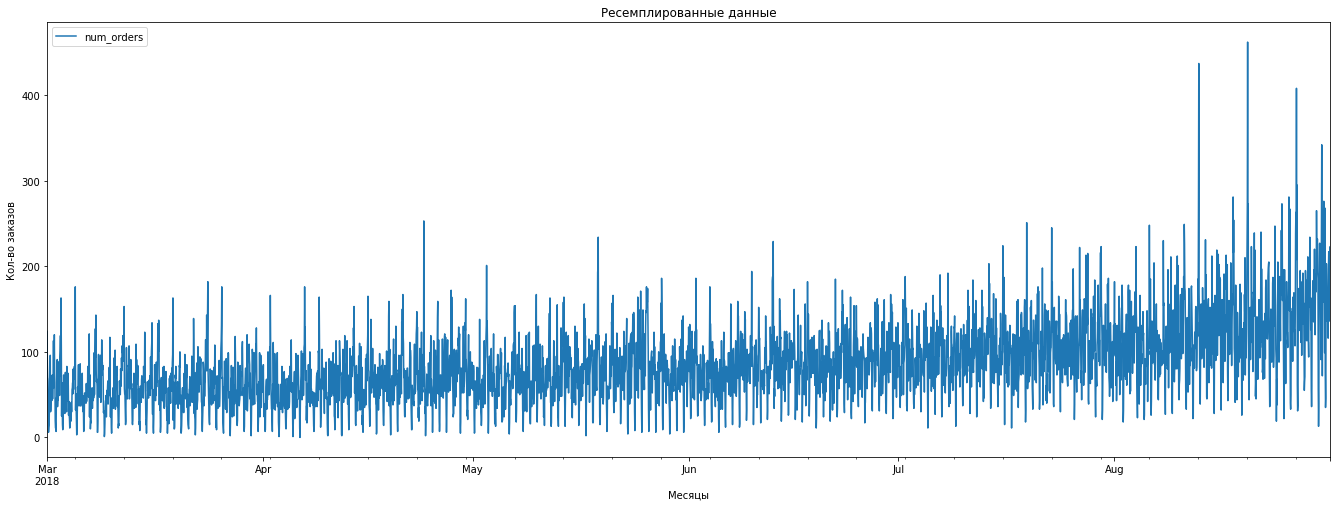

In [11]:
# Отобразим график ресемплированных данных:
figsize = (23,8)
data.plot(figsize=figsize)
plt.title('Ресемплированные данные')
plt.xlabel('Месяцы')
plt.ylabel('Кол-во заказов')
plt.show()

Ряд примерно до августа выглядит относительно стационарным, так как среднее значение практически не меняется, исходя из графика

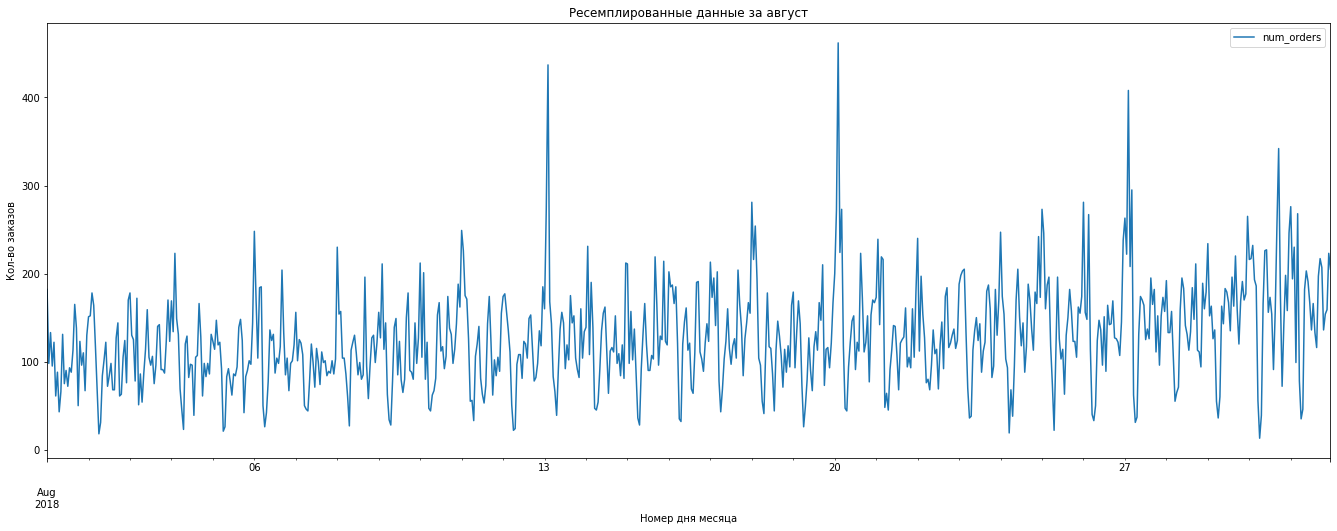

In [12]:
# Отобразим график за август:
data_august = data['2018-08-01':]
data_august.plot(figsize=figsize)
plt.title('Ресемплированные данные за август')
plt.xlabel('Номер дня месяца')
plt.ylabel('Кол-во заказов')
plt.show()

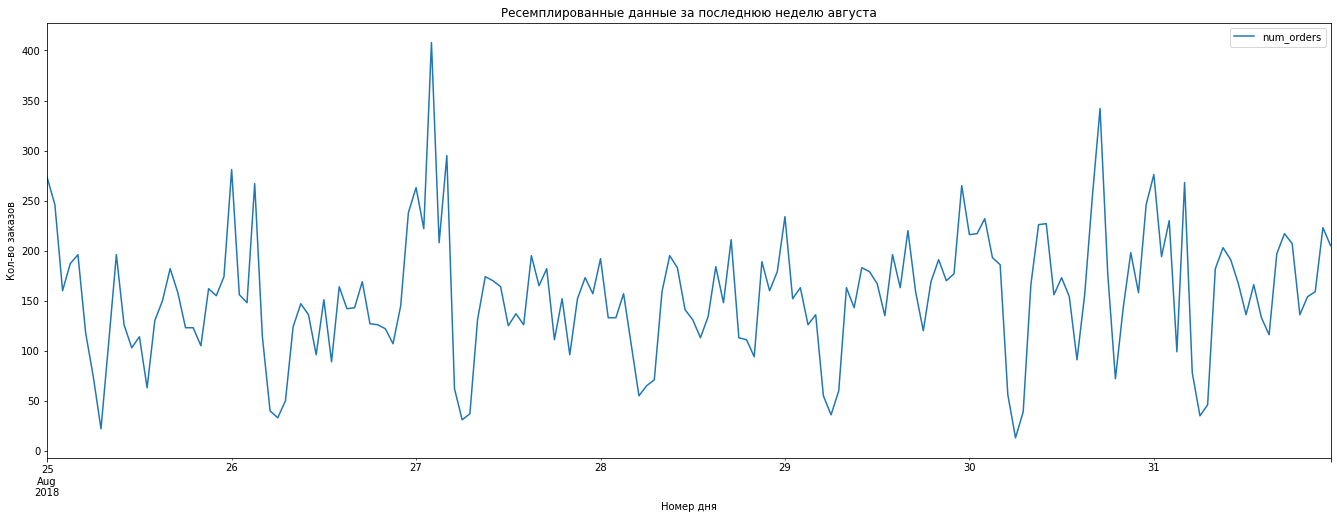

In [13]:
# Отобразим график за последнюю неделю августа:
data_august_last_7_days = data['2018-08-25':]
data_august_last_7_days.plot(figsize=figsize)
plt.title('Ресемплированные данные за последнюю неделю августа')
plt.xlabel('Номер дня')
plt.ylabel('Кол-во заказов')
plt.show()

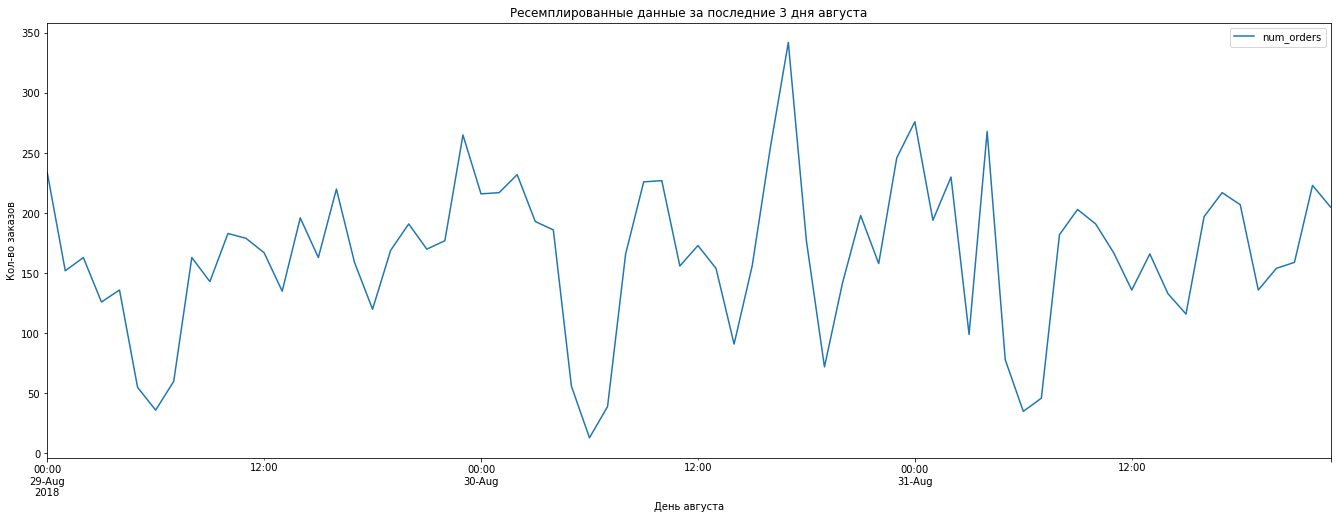

In [14]:
# Отобразим график за последние 3 дня августа:
data_august_last_3_days = data['2018-08-29':]
data_august_last_3_days.plot(figsize=figsize)
plt.title('Ресемплированные данные за последние 3 дня августа')
plt.xlabel('День августа')
plt.ylabel('Кол-во заказов')
plt.show()

Промежуточный вывод:

Исходя из графиков, можно сделать вывод, что кол-во заказов начинает возрастать, при этом есть всплески 6-го, 13-го, 20-го, 27-го. Если обратиться к календарю, то можно определить, что всплески происходят по понедельникам.
Исходя из последнего графика, заметен спад заказов по утрам и затем подъем к 12:00 часам дня.

Скользящее среднее

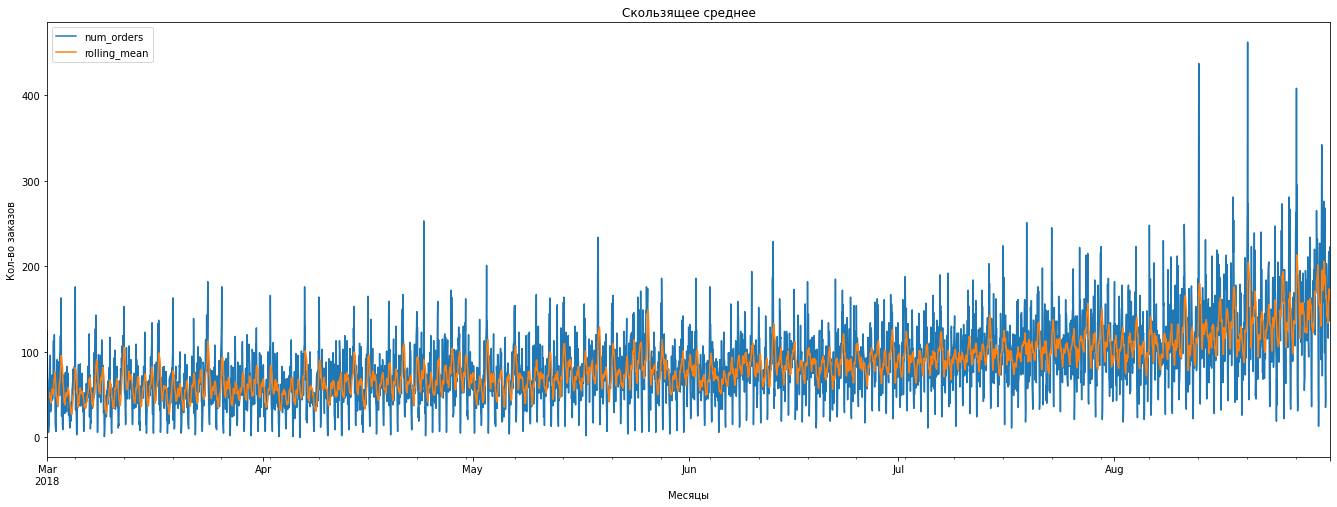

In [15]:
data['rolling_mean'] = data.rolling(10).mean()
data.plot(figsize=figsize)
plt.title('Скользящее среднее')
plt.xlabel('Месяцы')
plt.ylabel('Кол-во заказов')
plt.show()

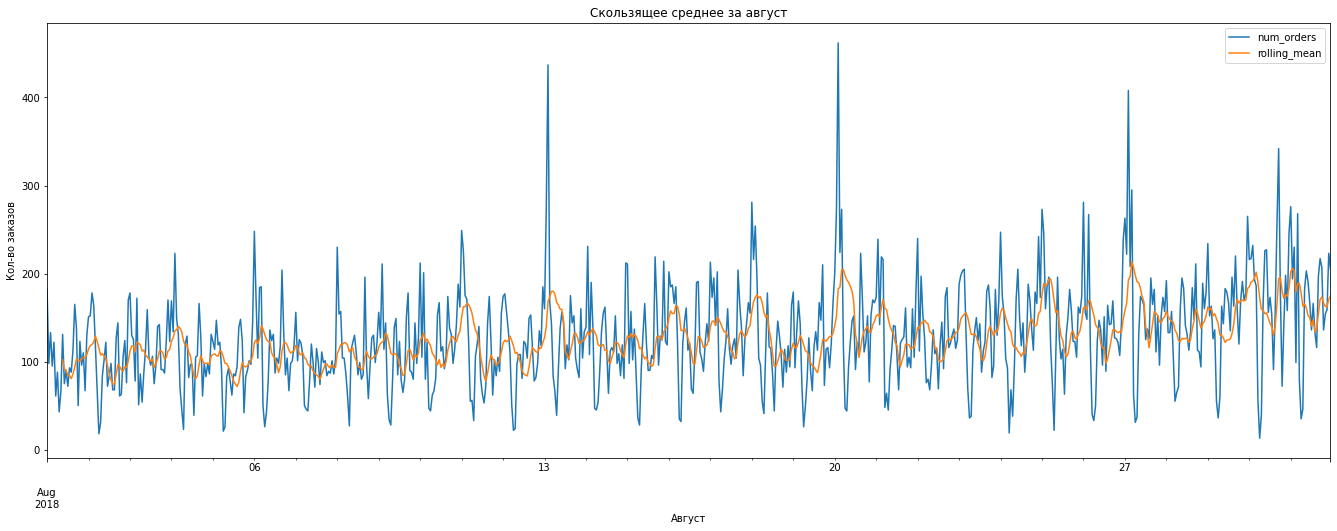

In [16]:
data_august['rolling_mean'] = data_august.rolling(10).mean()
data_august.plot(figsize=figsize)
plt.title('Скользящее среднее за август')
plt.xlabel('Август')
plt.ylabel('Кол-во заказов')
plt.show()

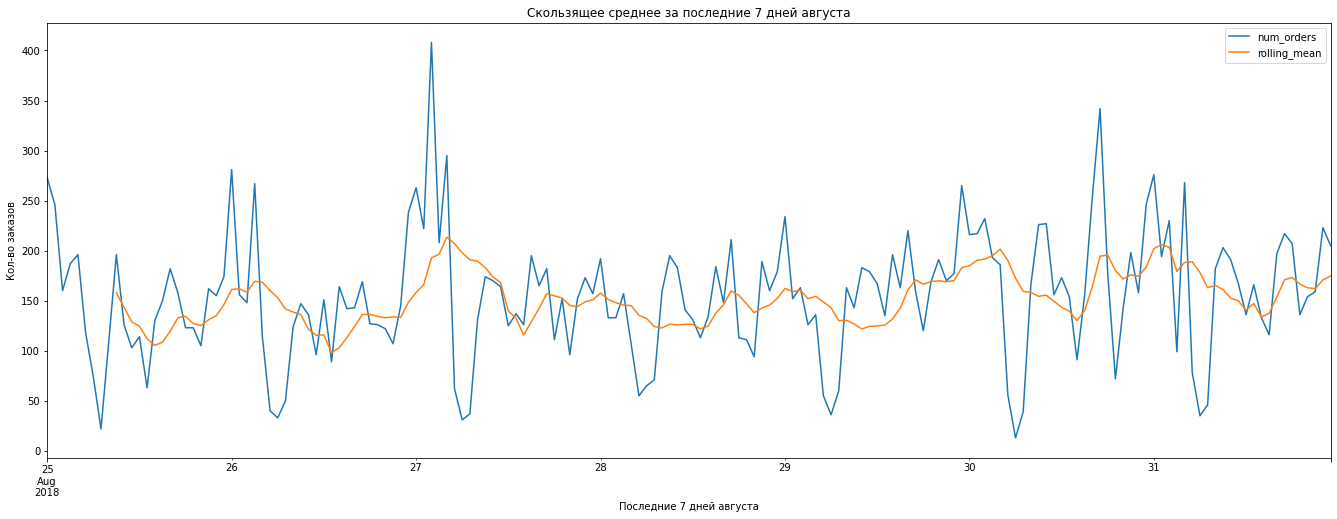

In [17]:
data_august_last_7_days['rolling_mean'] = data_august_last_7_days.rolling(10).mean()
data_august_last_7_days.plot(figsize=figsize)
plt.title('Скользящее среднее за последние 7 дней августа')
plt.xlabel('Последние 7 дней августа')
plt.ylabel('Кол-во заказов')
plt.show()

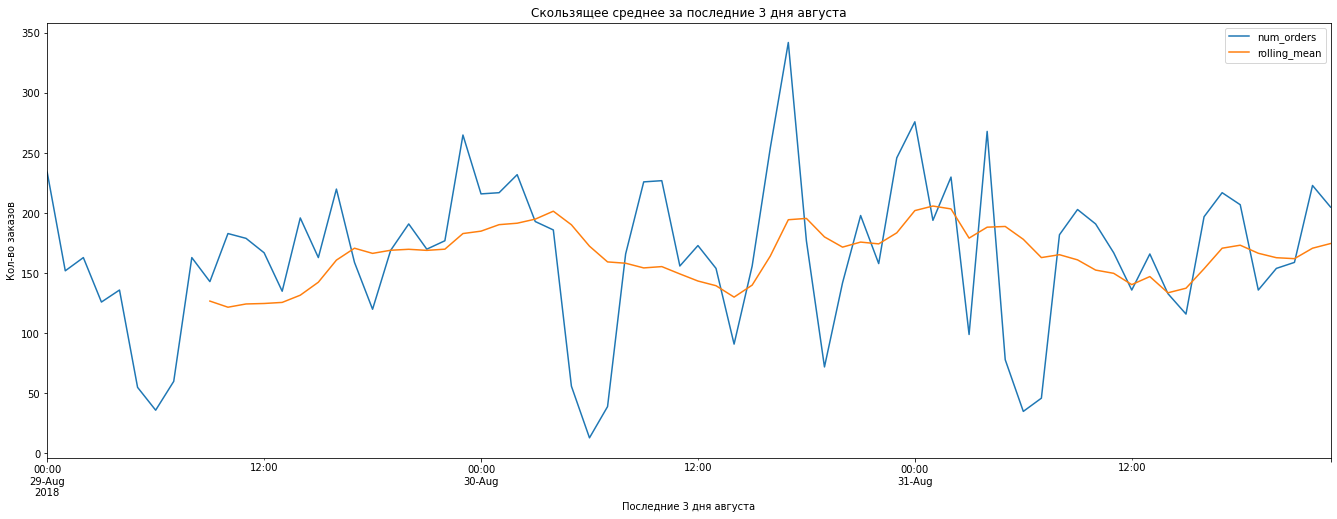

In [18]:
data_august_last_3_days['rolling_mean'] = data_august_last_3_days.rolling(10).mean()
data_august_last_3_days.plot(figsize=figsize)
plt.title('Скользящее среднее за последние 3 дня августа')
plt.xlabel('Последние 3 дня августа')
plt.ylabel('Кол-во заказов')
plt.show()

Декомпозиция

In [19]:
# декомпозируем данные:
decomposed = seasonal_decompose(data.num_orders)
decomposed_august = seasonal_decompose(data_august.num_orders)
decomposed_august_last_3_days = seasonal_decompose(data_august_last_3_days.num_orders)

Тренды за весь период, за последний месяц и последние 3 дня

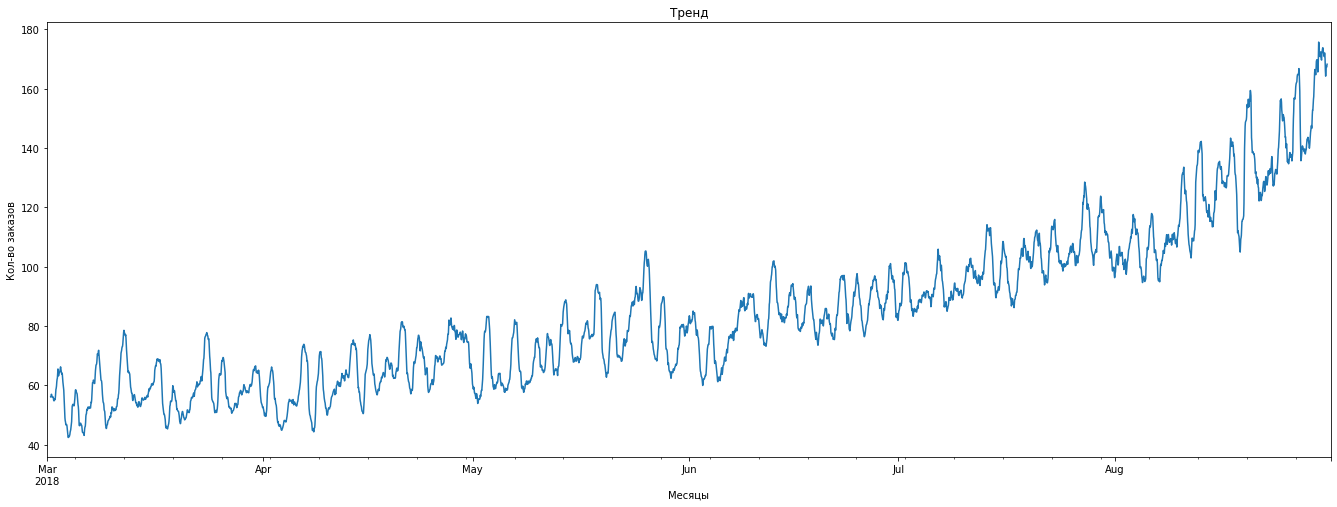

In [20]:
decomposed.trend.plot(figsize=figsize)
plt.title('Тренд')
plt.xlabel('Месяцы')
plt.ylabel('Кол-во заказов')
plt.show()

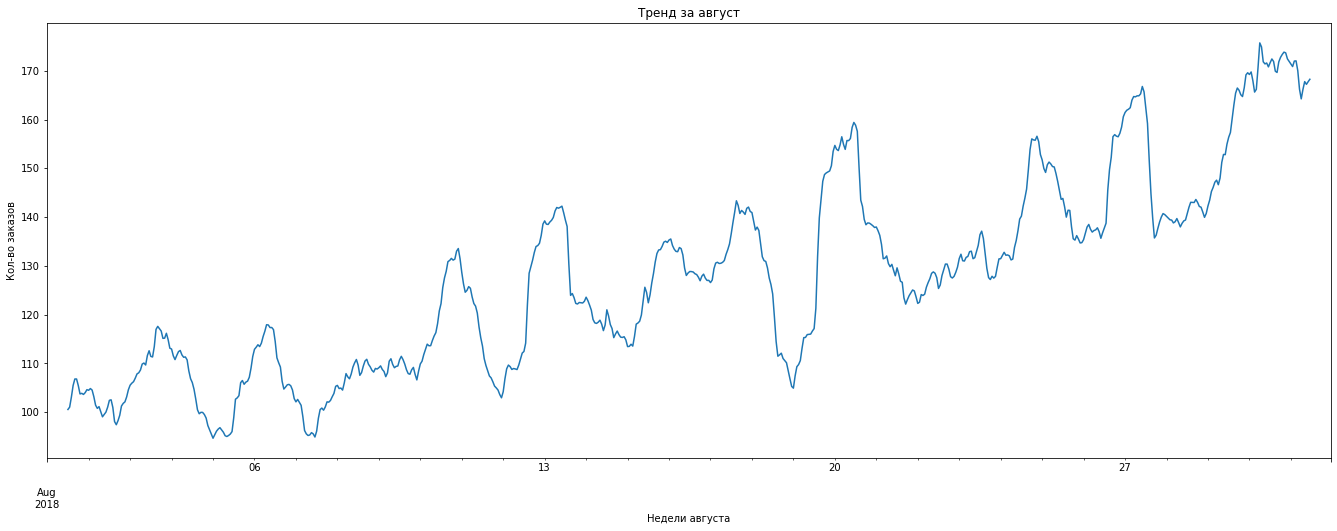

In [21]:
decomposed_august.trend.plot(figsize=figsize)
plt.title('Тренд за август')
plt.xlabel('Недели августа')
plt.ylabel('Кол-во заказов')
plt.show()

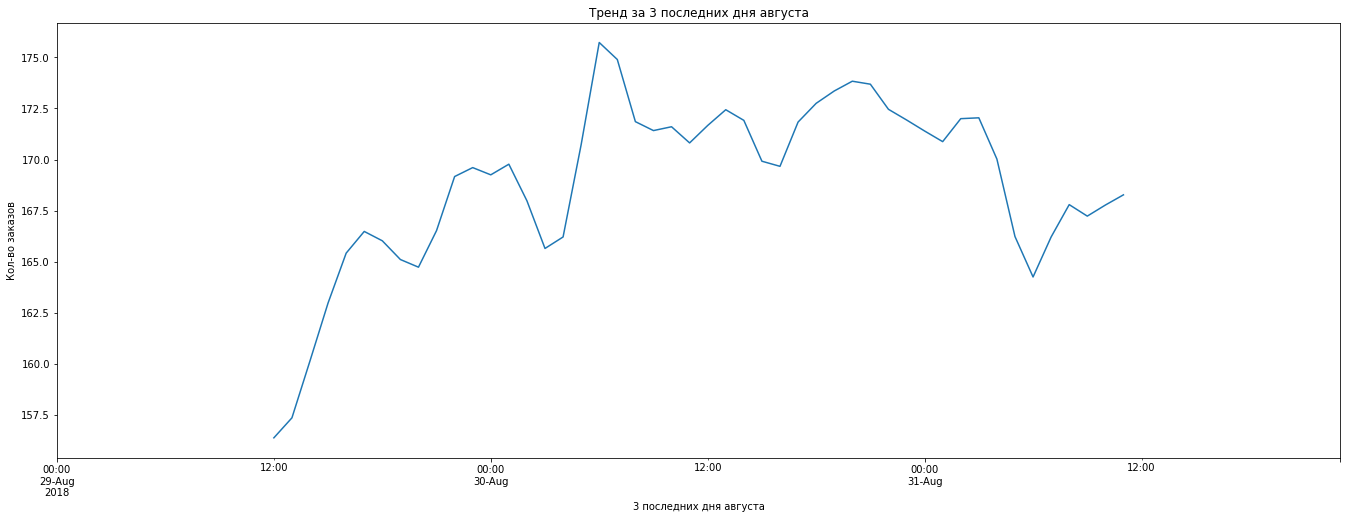

In [22]:
decomposed_august_last_3_days.trend.plot(figsize=figsize)
plt.title('Тренд за 3 последних дня августа')
plt.xlabel('3 последних дня августа')
plt.ylabel('Кол-во заказов')
plt.show()

Сезонность за весь период, за последний месяц и за последние 3 дня

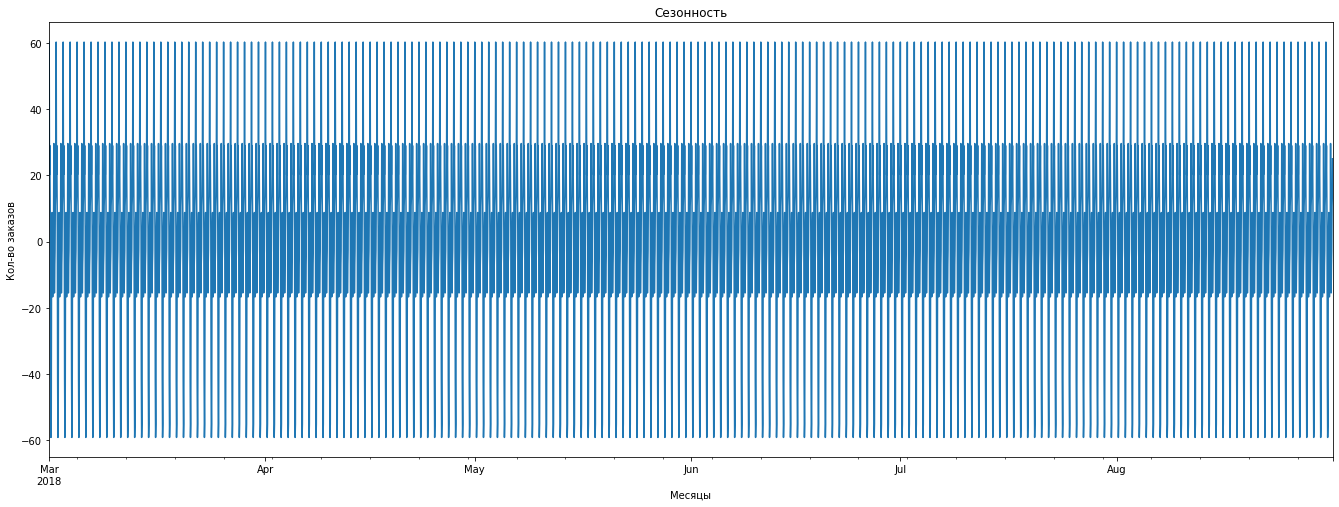

In [23]:
decomposed.seasonal.plot(figsize=figsize)
plt.title('Сезонность')
plt.xlabel('Месяцы')
plt.ylabel('Кол-во заказов')
plt.show()

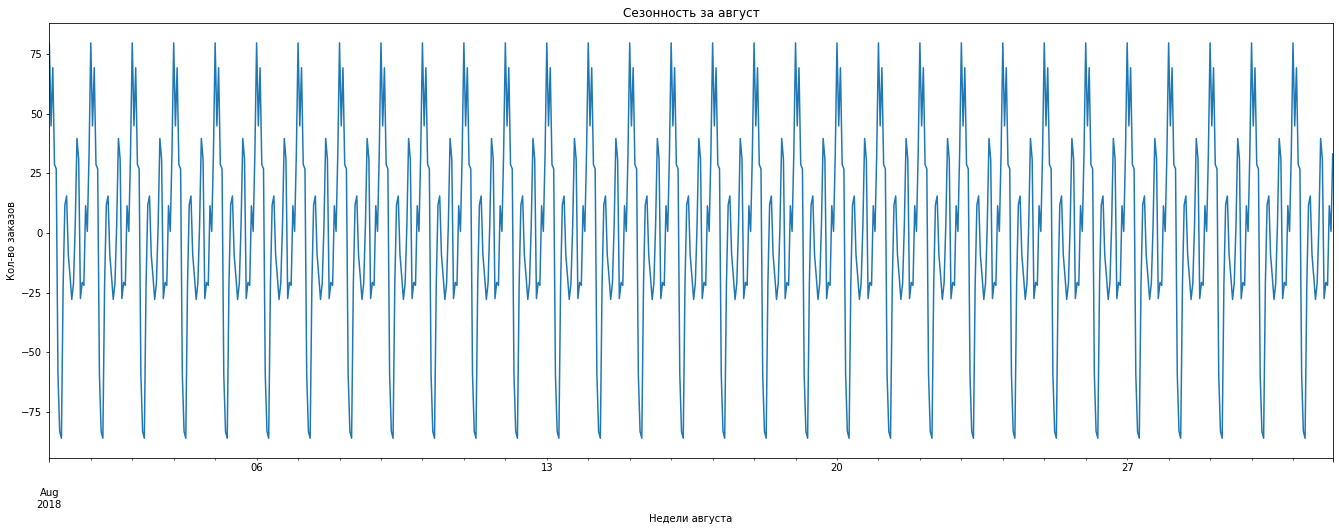

In [24]:
decomposed_august.seasonal.plot(figsize=figsize)
plt.title('Сезонность за август')
plt.xlabel('Недели августа')
plt.ylabel('Кол-во заказов')
plt.show()

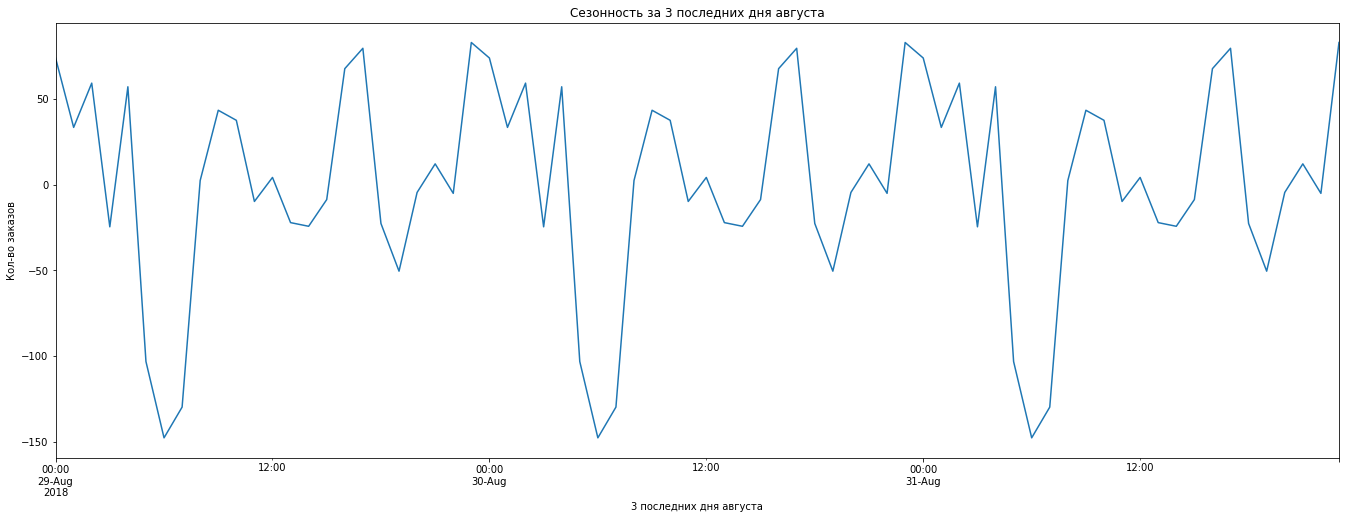

In [25]:
decomposed_august_last_3_days.seasonal.plot(figsize=figsize)
plt.title('Сезонность за 3 последних дня августа')
plt.xlabel('3 последних дня августа')
plt.ylabel('Кол-во заказов')
plt.show()

Промежуточный вывод: 

На графике сезонности за последние три дня наблюдается падение и минимум в районе 06:00 и 18:00 и рост заказов/максимум в районе 09:00 и 00:00

Остатки за весь период, за последний месяц и за последние 3 дня

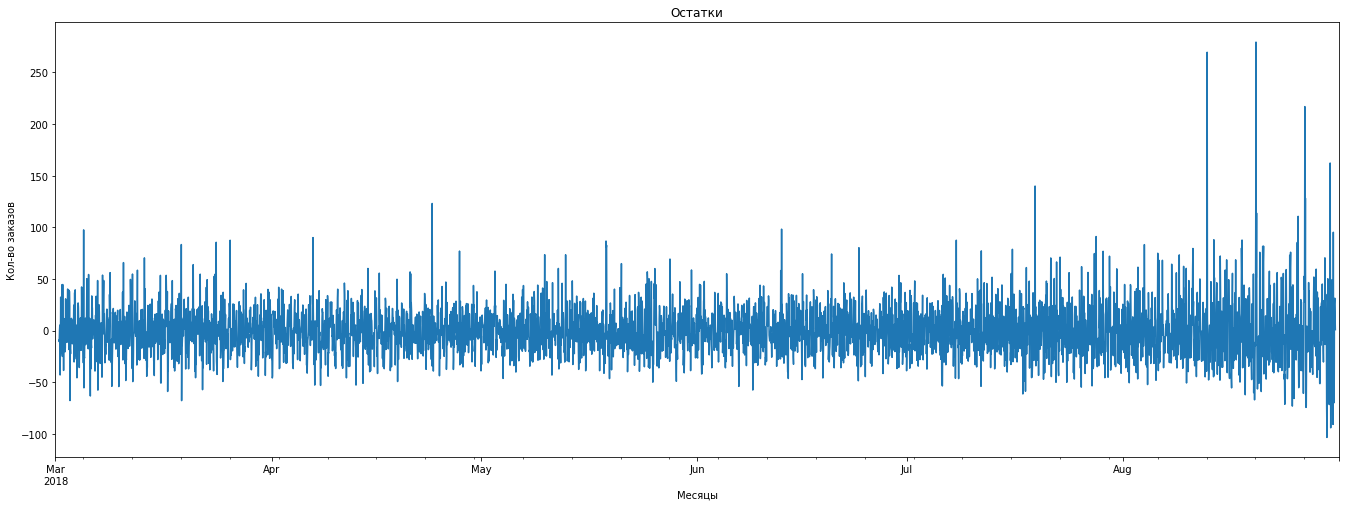

In [26]:
decomposed.resid.plot(figsize=figsize)
plt.title('Остатки')
plt.xlabel('Месяцы')
plt.ylabel('Кол-во заказов')
plt.show()

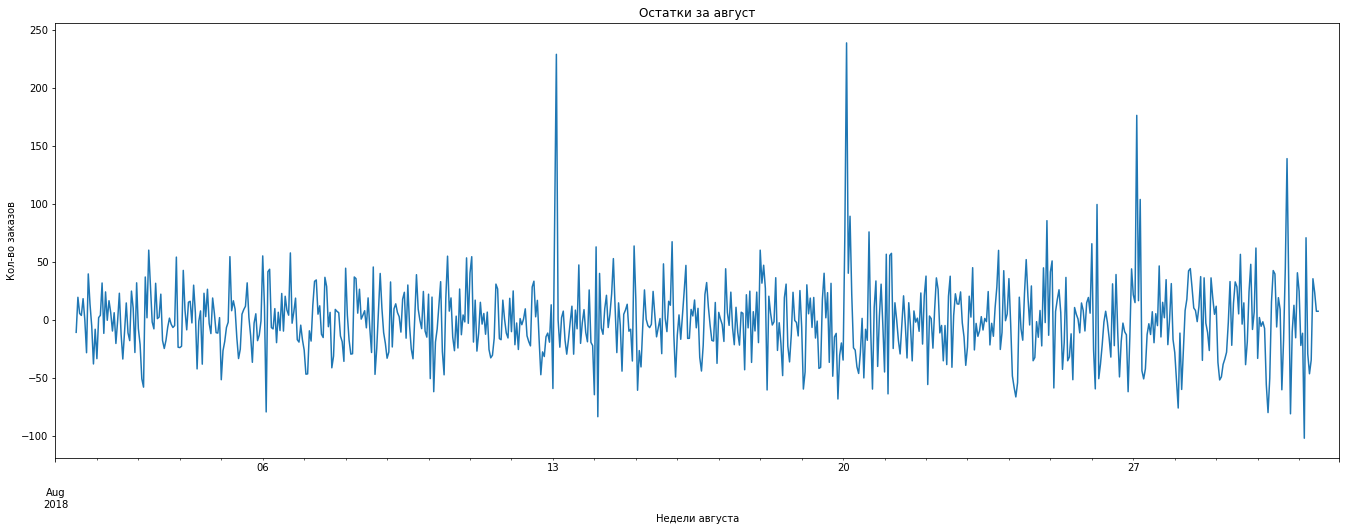

In [27]:
decomposed_august.resid.plot(figsize=figsize)
plt.title('Остатки за август')
plt.xlabel('Недели августа')
plt.ylabel('Кол-во заказов')
plt.show()

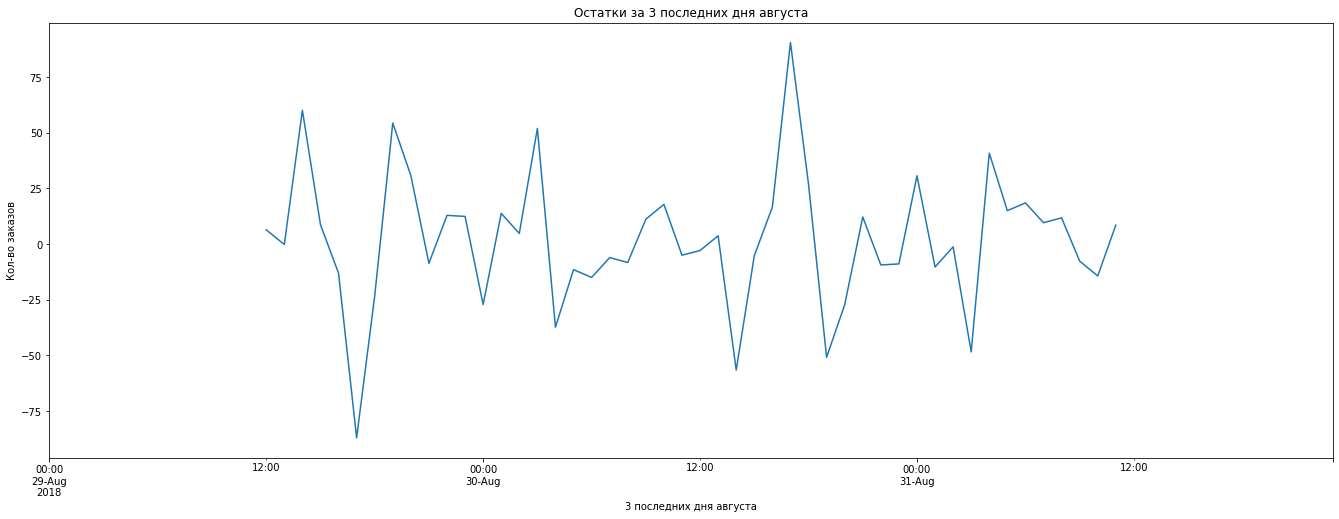

In [28]:
decomposed_august_last_3_days.resid.plot(figsize=figsize)
plt.title('Остатки за 3 последних дня августа')
plt.xlabel('3 последних дня августа')
plt.ylabel('Кол-во заказов')
plt.show()

Вывод:

Графики ресемплированных данных и графики трендов не стационарные, так как наблюдается возрастание.
На графиках остатков также наблюдаются всплески.
Заметна суточная сезонность - больше всего заказов в 09:00 и в 00:00, меньше всего в 06:00 и в 18:00. 
Таким образом, наиболее популярны вызовы такси из аэропорта на утренних и ночных рейсах.
День влияет на кол-во заказов. Наблюдается увеличение заказов по понедельникам.

## Обучение и тестирование

In [29]:
# Функция для признаков
def make_features(data, max_lag, rolling_mean_size):
    data = data.copy()
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data

Линейная регрессия

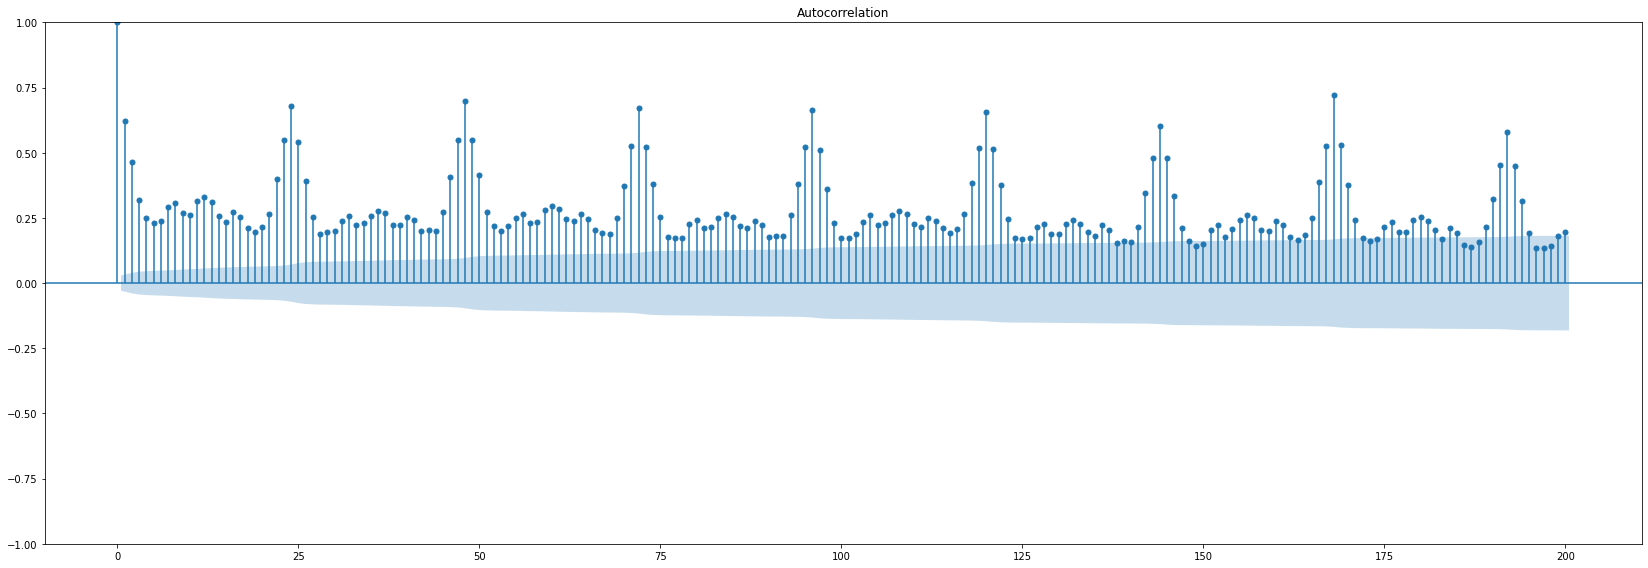

In [30]:
N, M = 23, 8
fig, ax = plt.subplots(figsize=(N, M))
plot_acf(data['num_orders'], lags=200, ax=ax)
plt.tight_layout()

In [31]:
tscv = TimeSeriesSplit(n_splits=3)

In [32]:
def rmse(predict, actual):
    
    score = mean_squared_error(actual, predict, squared=False)
    
    return score

In [33]:
rmse_score = make_scorer(rmse, greater_is_better = False)

In [34]:
model_linear = LinearRegression()

def linear_model_cv(X, y):
    
    scores =[]
    cv = cross_val_score(model_linear, X, y, cv=tscv, scoring=rmse_score) 
    scores.append(cv)
    mean_rmse = abs(np.mean(scores))
    
    return mean_rmse

In [35]:
# Обучим и проверим модель с разными гиперпараметрами

reference_rmse = 48
time_range = [24, 48, 72, 96, 120, 144, 169]

for max_lag in time_range:
    for rolling_mean_size in time_range:
        data = make_features(data, max_lag, rolling_mean_size)
        
        train, valid = train_test_split(data, shuffle=False, test_size=0.2)
        train = train.dropna()

        valid, test = train_test_split(valid, shuffle=False, test_size=0.5)
        
        features_train = train.drop('num_orders', axis=1)
        target_train = train.num_orders

        features_valid = valid.drop('num_orders', axis=1)
        target_valid = valid.num_orders
    
        features_test = test.drop('num_orders', axis=1)
        target_test = test.num_orders
        
        rmse = linear_model_cv(features_train, target_train) 
        
        if rmse < reference_rmse:
            reference_rmse = rmse
            best_max_lag = max_lag
            best_rolling_mean_size = rolling_mean_size
            
print('лучшее RMSE модели линейной регрессии на валидационной выборке: =', 
      reference_rmse, 'при лаге', best_max_lag, ', окне', best_rolling_mean_size)

лучшее RMSE модели линейной регрессии на валидационной выборке: = 22.11913452628396 при лаге 169 , окне 96


LightGBMRegressor

In [36]:
model = LGBMRegressor() 

param_grid_LGBM = {
    'lgbmregressor__num_leaves': (25, 50, 100, 200),
    'lgbmregressor__learning_rate': (0.1, 0.3, 0.5)
}

tscv = TimeSeriesSplit(n_splits=3)
gs_LGBM = GridSearchCV(estimator=model,  
                      cv=tscv,
                      scoring = 'neg_root_mean_squared_error',
                      param_grid=param_grid_LGBM)

gs_LGBM.fit(features_train, target_train)

[LightGBM] [Warning] Unknown parameter: lgbmregressor__num_leaves
[LightGBM] [Warning] Unknown parameter: lgbmregressor__learning_rate
[LightGBM] [Warning] Unknown parameter: lgbmregressor__num_leaves
[LightGBM] [Warning] Unknown parameter: lgbmregressor__learning_rate
[LightGBM] [Warning] Unknown parameter: lgbmregressor__num_leaves
[LightGBM] [Warning] Unknown parameter: lgbmregressor__learning_rate
[LightGBM] [Warning] Unknown parameter: lgbmregressor__num_leaves
[LightGBM] [Warning] Unknown parameter: lgbmregressor__learning_rate
[LightGBM] [Warning] Unknown parameter: lgbmregressor__num_leaves
[LightGBM] [Warning] Unknown parameter: lgbmregressor__learning_rate
[LightGBM] [Warning] Unknown parameter: lgbmregressor__num_leaves
[LightGBM] [Warning] Unknown parameter: lgbmregressor__learning_rate
[LightGBM] [Warning] Unknown parameter: lgbmregressor__num_leaves
[LightGBM] [Warning] Unknown parameter: lgbmregressor__learning_rate
[LightGBM] [Warning] Unknown parameter: lgbmregressor__

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=LGBMRegressor(),
             param_grid={'lgbmregressor__learning_rate': (0.1, 0.3, 0.5),
                         'lgbmregressor__num_leaves': (25, 50, 100, 200)},
             scoring='neg_root_mean_squared_error')

In [37]:
gs_LGBM_best_score = gs_LGBM.best_score_ * -1
gs_LGBM_best_params = gs_LGBM.best_params_
print(f'best_score: {gs_LGBM_best_score}')
print(f'best_params: {gs_LGBM_best_params}')

best_score: 22.19700185120899
best_params: {'lgbmregressor__learning_rate': 0.1, 'lgbmregressor__num_leaves': 25}


In [38]:
mts = gs_LGBM.cv_results_['mean_test_score']

rsme = (max(mts) * -1) ** 0.5
print('RMSE LightGBMRegressor на тренировочной выборке =', rmse)

RMSE LightGBMRegressor на тренировочной выборке = 22.11913452628397


In [39]:
result = pd.DataFrame(
    [reference_rmse, gs_LGBM_best_score],
    index=['Linear Regression', 'LGBM'],
    columns=['RMSE']
)
result

,RMSE
Linear Regression,22.119135
LGBM,22.197002


In [40]:
model_linear.fit(features_train, target_train)  

# Сделаем предсказание на тестовой выборке
predictions = model_linear.predict(features_test)

In [41]:
rmse = np.sqrt(mean_squared_error(target_test, predictions))
print('RMSE:', rmse)

RMSE: 34.96259092770197


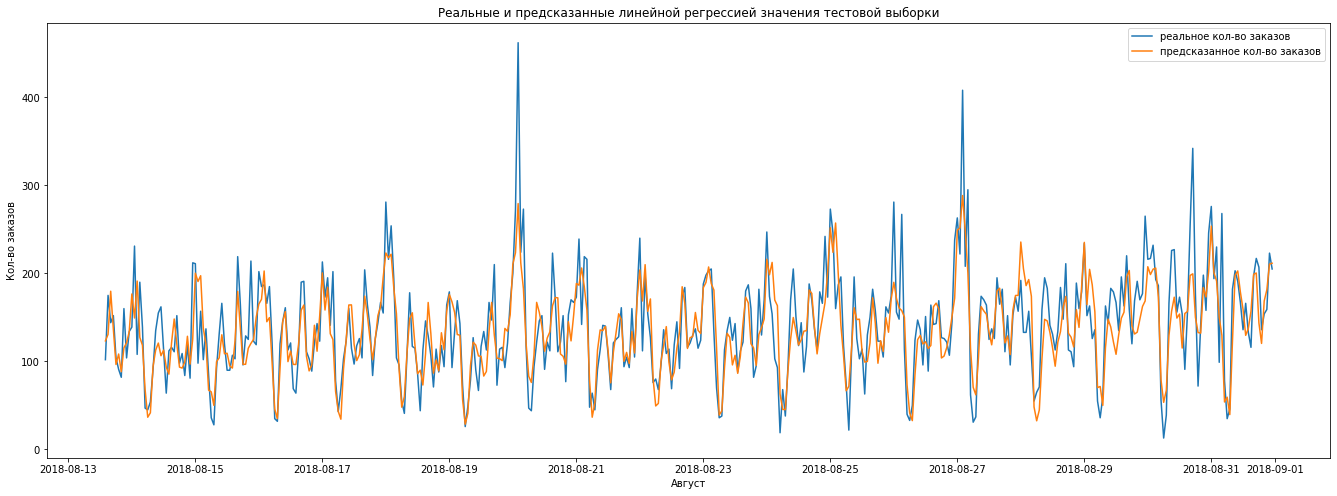

In [42]:
# Отобразим на графике реальные и предсказанные значения тестовой выборки
fig, ax = plt.subplots(figsize=figsize)
ax.plot(target_test.index, target_test, label='реальное кол-во заказов')
ax.plot(target_test.index, predictions, label='предсказанное кол-во заказов')
plt.title('Реальные и предсказанные линейной регрессией значения тестовой выборки')
plt.xlabel('Август')
plt.ylabel('Кол-во заказов')
plt.legend()
plt.show()

Графики идут близко друг к другу, что говорит о том, что линейная регрессия дает достаточно точные предсказания, за исключением всплесков на остатках.

Вывод:
Обучили 2 модели - линейную регрессию, и LGBMRegressor.
Наилучший результат дала линейная регрессия - на тестовой выборке RMSE = 44

## Вывод

Загрузили данные. Провели анализ, заметили, что ряд не стационарный.
Сравнили 2 модели с разными гиперпараметрами, проверили их на тестовых выборках.
Наилучшей моделью оказалась линейная регрессия, RMSE < 48